In [4]:
import sys
sys.path.append('/home/fenglab/Desktop/transdiff_GRN/src/')

import gzip
from glob import glob
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multitest import multipletests

from PoLoBag import *

#### Reformat RPM from each sample

In [2]:
files = sorted(glob('./../../data/GSE208199/raw/*.txt.gz'))

In [3]:
d = {}
for f in files:
    with gzip.open(f,'rb') as f:
        lst = [x.decode('utf8').strip() for x in f.readlines()]
    d[lst[0].split('\t')[1]] = [n.split('\t')[1] for n in lst][1:]
geneids = [n.split('\t')[0] for n in lst][1:]

In [34]:
df = pd.DataFrame(d, index=geneids)
df.index.name='geneid'

In [36]:
df.to_csv('./../../data/GSE208199/matrix.csv')

#### Select most differentially expressed genes between groups and time points

In [15]:
def group_anova(geneid, df):
    '''2 way anova'''
    lst_treatment = ['Ascl1p']*10+['Ascl1n']*10+['Ngn2p']*10+['Ngn2n']*10
    lst_day = (['d0']*2+['d2']*2+['d3']*2+['d4']*2+['d6']*2)*4
    df_gene = pd.DataFrame(df.loc[geneid])
    df_gene['treatment'] = lst_treatment
    df_gene['day'] = lst_day
    df_melt = pd.melt(df_gene, id_vars=['treatment', 'day'], value_vars=[geneid])
    model = ols('value ~ C(treatment) + C(day) + C(treatment):C(day)', data = df_melt).fit()
    table = sm.stats.anova_lm(model, typ = 2)
    result = np.array(table['PR(>F)'][:3])
    return result

In [2]:
df = pd.read_csv('./../../data/GSE208199/matrix.csv').set_index('geneid')
df = np.log2(df+1)
df = df[df.max(axis=1)>2]

In [8]:
df['mean'] = df.to_numpy().mean(axis=1)
df['0_ct'] = (df==0).to_numpy().sum(axis=1)

In [10]:
df = df[(df['mean']>0)&(df['0_ct']<=28)]
df = df[~df.index.duplicated()]
df = df.drop(columns=['mean','0_ct'])

In [13]:
df.columns

Index(['Ascl1_ESC_1', 'Ascl1_ESC_2', 'Ascl1_D2_1', 'Ascl1_D2_2',
       'Ascl1_D3_GFPpos_1', 'Ascl1_D3_GFPpos_2', 'Ascl1_D3_GFPneg_1',
       'Ascl1_D3_GFPneg_2', 'Ascl1_D4_GFPpos_1', 'Ascl1_D4_GFPpos_2',
       'Ascl1_D4_GFPneg_1', 'Ascl1_D4_GFPneg_2', 'Ascl1_D6_GFPpos_1',
       'Ascl1_D6_GFPpos_2', 'Ascl1_D6_GFPneg_1', 'Ascl1_D6_GFPneg_2',
       'Ngn2_ESC_1', 'Ngn2_ESC_2', 'Ngn2_D2_combi_1', 'Ngn2_D2_combi_2',
       'Ngn2_D3_GFPpos_1', 'Ngn2_D3_GFPpos_2', 'Ngn2_D3_GFPneg_1',
       'Ngn2_D3_GFPneg_2', 'Ngn2_D4_GFPpos_1', 'Ngn2_D4_GFPpos_2',
       'Ngn2_D4_GFPneg_1', 'Ngn2_D4_GFPneg_2', 'Ngn2_D6_GFPpos_1',
       'Ngn2_D6_GFPpos_2', 'Ngn2_D6_GFPneg_1', 'Ngn2_D6_GFPneg_2'],
      dtype='object')

In [3]:
df = df[['Ascl1_ESC_1', 'Ascl1_ESC_2', 'Ascl1_D2_1', 'Ascl1_D2_2',
    'Ascl1_D3_GFPpos_1', 'Ascl1_D3_GFPpos_2','Ascl1_D4_GFPpos_1', 'Ascl1_D4_GFPpos_2',
    'Ascl1_D6_GFPpos_1','Ascl1_D6_GFPpos_2',
    'Ascl1_ESC_1', 'Ascl1_ESC_2', 'Ascl1_D2_1', 'Ascl1_D2_2',
    'Ascl1_D3_GFPneg_1','Ascl1_D3_GFPneg_2','Ascl1_D4_GFPneg_1', 'Ascl1_D4_GFPneg_2',
    'Ascl1_D6_GFPneg_1', 'Ascl1_D6_GFPneg_2',
    'Ngn2_ESC_1', 'Ngn2_ESC_2', 'Ngn2_D2_combi_1', 'Ngn2_D2_combi_2',
    'Ngn2_D3_GFPpos_1', 'Ngn2_D3_GFPpos_2','Ngn2_D4_GFPpos_1', 'Ngn2_D4_GFPpos_2',
    'Ngn2_D6_GFPpos_2', 'Ngn2_D6_GFPneg_1',
    'Ngn2_ESC_1', 'Ngn2_ESC_2', 'Ngn2_D2_combi_1', 'Ngn2_D2_combi_2',
    'Ngn2_D3_GFPneg_1','Ngn2_D3_GFPneg_2', 'Ngn2_D4_GFPneg_1', 'Ngn2_D4_GFPneg_2',
    'Ngn2_D6_GFPneg_1', 'Ngn2_D6_GFPneg_2']]

In [16]:
anova_ls = np.empty((len(df), 3))
for n in range(len(df)):
    anova_ls[n, :] = group_anova(list(df.index)[n], df)
dfpval = pd.DataFrame(anova_ls, index = df.index, columns = ['treatment', 'day', 'interaction'])

In [21]:
lst1 = list(dfpval.sort_values(by = 'treatment')[:450].index)
lst2 = list(dfpval.sort_values(by = 'day')[:450].index)

In [25]:
df = pd.read_csv('./../../data/GSE208199/matrix.csv').set_index('geneid')

In [26]:
df[df.index.isin(lst1+lst2)].to_csv('./../../data/GSE208199/grn_expression_t5.txt', sep='\t')

#### Check sample separation by PCA

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
rcParams['font.family']='arial'
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
colors = {'Ascl1p':'#24a394', 'Ascl1n':'#03574d', 'Ngn2p':'#b5971d', 'Ngn2n':'#705b06'}

In [12]:
with open('./../../data/GSE208199/grn_expression_t5.txt', 'r') as f:
    lines = f.readlines()

In [10]:
df = pd.DataFrame([line[:-2].split('\t') for line in lines[1:]], columns=lines[0][:-2].split('\t'))
df = df.set_index('geneid')

In [30]:
pc_scale = np.log2(df.to_numpy(float)+1).T
pca = PCA(n_components=2)
pca.fit(pc_scale)
pca_value = pca.transform(pc_scale)
pc_r = pca.explained_variance_ratio_*100

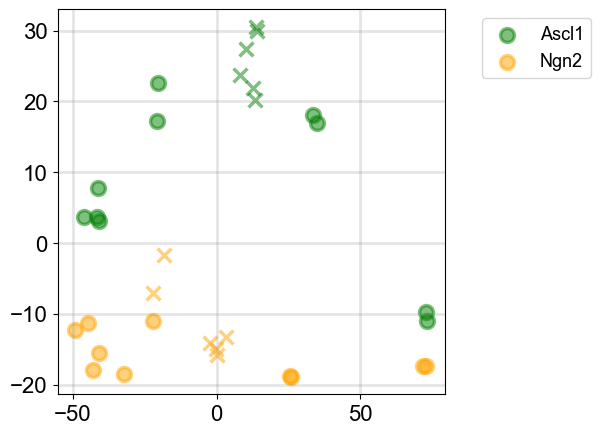

In [31]:
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
rcParams['font.family']='arial'
rcParams.update({'font.size': 16})
plt.figure(figsize=(5, 5))

plt.scatter(pca_value[:6, 0], pca_value[:6,1], s=100, marker='o',linewidths=2.5,
            alpha=0.5, edgecolors='green', color = 'green', label='Ascl1')
plt.scatter(pca_value[6:8, 0], pca_value[6:8,1], s=100, marker='x',linewidths=2.5,
            alpha=0.5, color = 'green')
plt.scatter(pca_value[8:10, 0], pca_value[8:10,1], s=100, marker='o',linewidths=2.5,
            alpha=0.5, edgecolors='green', color = 'green')
plt.scatter(pca_value[10:12, 0], pca_value[10:12,1], s=100, marker='x',linewidths=2.5,
            alpha=0.5, color = 'green')
plt.scatter(pca_value[12:14, 0], pca_value[12:14,1], s=100, marker='o',linewidths=2.5,
            alpha=0.5, edgecolors='green', color = 'green')
plt.scatter(pca_value[14:16, 0], pca_value[14:16,1], s=100, marker='x',linewidths=2.5,
            alpha=0.5, color = 'green')

plt.scatter(pca_value[16:22, 0], pca_value[16:22,1], s=100, marker='o',linewidths=2.5,
            alpha=0.5, edgecolors='orange', color = 'orange', label='Ngn2')
plt.scatter(pca_value[22:24, 0], pca_value[22:24,1], s=100, marker='x',linewidths=2.5,
            alpha=0.5, color = 'orange')
plt.scatter(pca_value[24:26, 0], pca_value[24:26,1], s=100, marker='o',linewidths=2.5,
            alpha=0.5, edgecolors='orange', color = 'orange')
plt.scatter(pca_value[26:28, 0], pca_value[26:28,1], s=100, marker='x',linewidths=2.5,
            alpha=0.5, color = 'orange')
plt.scatter(pca_value[28:30, 0], pca_value[28:30,1], s=100, marker='o',linewidths=2.5,
            alpha=0.5, edgecolors='orange', color = 'orange')
plt.scatter(pca_value[30:32, 0], pca_value[30:32,1], s=100, marker='x',linewidths=2.5,
            alpha=0.5, color = 'orange')
plt.grid(linewidth=2, alpha=0.2, color='grey')
plt.legend(bbox_to_anchor=(1.4,1), prop={'size':13})


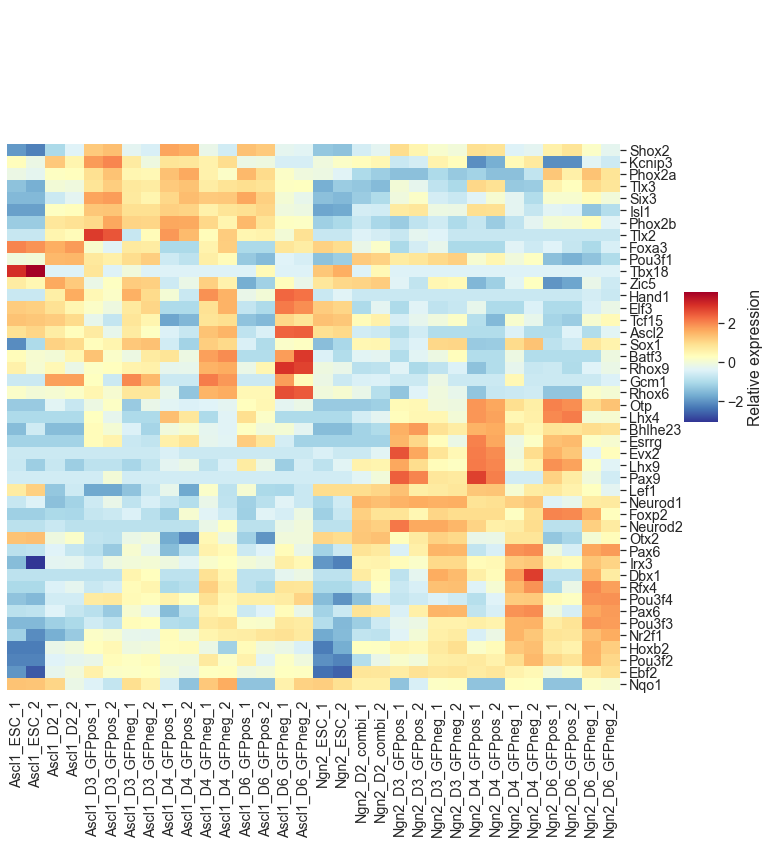

In [5]:
ylabel = ['Shox2', 'Kcnip3', 'Phox2a', 'Tlx3', 'Six3', 'Isl1',
          'Phox2b', 'Tlx2', 'Foxa3', 'Pou3f1', 'Tbx18',
          'Zic5', 'Hand1', 'Elf3', 'Tcf15', 'Ascl2', 'Sox1',
          'Batf3', 'Rhox9', 'Gcm1', 'Rhox6',
          'Otp', 'Lhx4', 'Bhlhe23', 'Esrrg', 'Evx2',
          'Lhx9', 'Pax9','Lef1','Neurod1' ,'Foxp2', 'Neurod2',
          'Otx2', 'Pax6', 'Irx3', 'Dbx1','Rfx4', 'Pou3f4',
          'Pax6','Pou3f3','Nr2f1','Hoxb2', 'Pou3f2','Ebf2','Nqo1']
xlabel = df.columns

fig = sns.clustermap(np.log2(df.loc[ylabel].to_numpy(float)+1), yticklabels=ylabel, col_cluster=False, xticklabels=xlabel,row_cluster=False, 
                     cmap='RdYlBu_r', figsize=(12,12), method='average', z_score=0,
                     cbar_kws={'shrink':0.08, 'label':'Relative expression'}, 
                     cbar_pos=(0.98, 0.5, 0.04, 0.15))
sns.set(font_scale=1.3)
fig.ax_row_dendrogram.set_visible(False)

In [4]:
def plot_line(gene, df):
    ary = df.loc[gene].to_numpy().reshape((4,10))
    fig = plt.figure(figsize=(2.3,4))
    ax = fig.add_subplot(1, 1, 1)
    plt.plot(np.arange(5), np.mean(ary[0,:].reshape((5,2)), axis=1), linewidth=3, color=colors['Ascl1p'], label='Ascl1+',zorder=10)
    plt.plot(np.arange(5), np.mean(ary[1,:].reshape((5,2)), axis=1), linewidth=3, color=colors['Ascl1n'], label='Ascl1-',linestyle='--')
    plt.plot(np.arange(5), np.mean(ary[2,:].reshape((5,2)), axis=1), linewidth=3, color=colors['Ngn2p'], label='Ngn2+',zorder=10)
    plt.plot(np.arange(5), np.mean(ary[3,:].reshape((5,2)), axis=1), linewidth=3, color=colors['Ngn2n'], label='Ngn2-',linestyle='--')

    plt.scatter(np.arange(5).repeat(2), ary[0,:],s=5, color=colors['Ascl1p'])
    plt.scatter(np.arange(5).repeat(2), ary[1,:],s=5, color=colors['Ascl1n'])
    plt.scatter(np.arange(5).repeat(2), ary[2,:],s=5, color=colors['Ngn2p'])
    plt.scatter(np.arange(5).repeat(2), ary[3,:],s=5, color=colors['Ngn2n'])

    plt.legend(loc='upper right', bbox_to_anchor=(1.7,1.0), frameon=False, prop={'size':13})
    plt.yticks(fontsize=13)
    plt.xticks([0,1,2,3,4], ['ESC','2','3','4','6'], fontsize=16)
    plt.ylabel('log2 (RPM+1)', fontsize=16)
    plt.xlabel('Day', fontsize=16)
    plt.title(gene, fontsize=16)
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

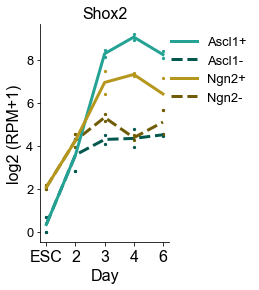

In [7]:
plot_line('Shox2',df)

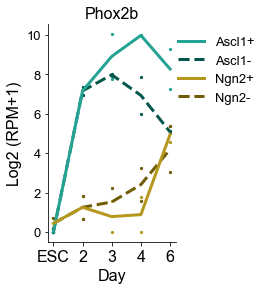

In [68]:
plot_line('Phox2b',df)

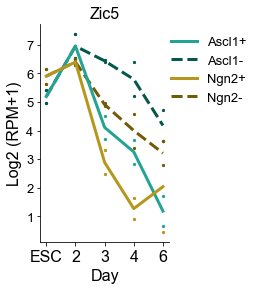

In [69]:
plot_line('Zic5',df)

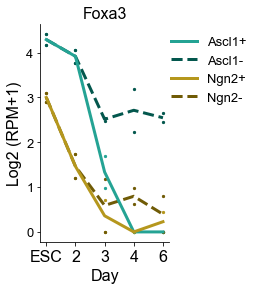

In [70]:
plot_line('Foxa3',df)

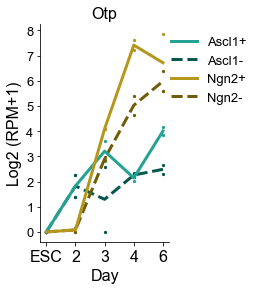

In [71]:
plot_line('Otp',df)

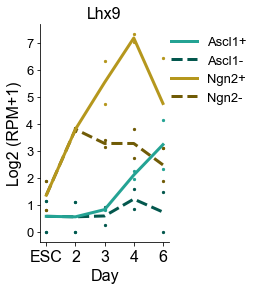

In [72]:
plot_line('Lhx9',df)

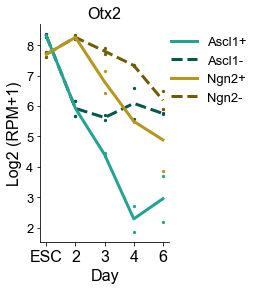

In [73]:
plot_line('Otx2',df)

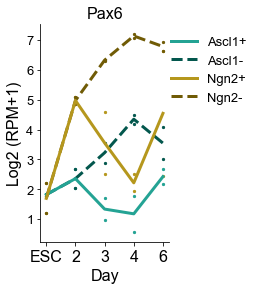

In [74]:
plot_line('Pax6',df)

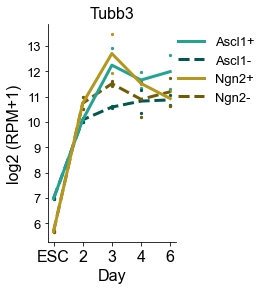

In [8]:
plot_line('Tubb3',df)

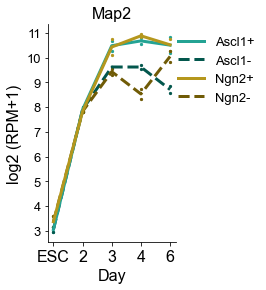

In [9]:
plot_line('Map2',df)

#### GRN inference

In [16]:
df.columns

Index(['Ascl1_ESC_1', 'Ascl1_ESC_2', 'Ascl1_D2_1', 'Ascl1_D2_2',
       'Ascl1_D3_GFPpos_1', 'Ascl1_D3_GFPpos_2', 'Ascl1_D3_GFPneg_1',
       'Ascl1_D3_GFPneg_2', 'Ascl1_D4_GFPpos_1', 'Ascl1_D4_GFPpos_2',
       'Ascl1_D4_GFPneg_1', 'Ascl1_D4_GFPneg_2', 'Ascl1_D6_GFPpos_1',
       'Ascl1_D6_GFPpos_2', 'Ascl1_D6_GFPneg_1', 'Ascl1_D6_GFPneg_2',
       'Ngn2_ESC_1', 'Ngn2_ESC_2', 'Ngn2_D2_combi_1', 'Ngn2_D2_combi_2',
       'Ngn2_D3_GFPpos_1', 'Ngn2_D3_GFPpos_2', 'Ngn2_D3_GFPneg_1',
       'Ngn2_D3_GFPneg_2', 'Ngn2_D4_GFPpos_1', 'Ngn2_D4_GFPpos_2',
       'Ngn2_D4_GFPneg_1', 'Ngn2_D4_GFPneg_2', 'Ngn2_D6_GFPpos_1',
       'Ngn2_D6_GFPpos_2', 'Ngn2_D6_GFPneg_1', 'Ngn2_D6_GFPneg_2'],
      dtype='object')

In [9]:
infile = './../../data/GSE208199/grn_expression_t5.txt'
outfile_prefix = './../../results/GSE208199/GRN/'

treatments = ['Ascl1p', 'Ascl1n', 'Ngn2p', 'Ngn2n']

sample_select = {'Ascl1p':np.array([1,1,1,1,1,1,0,0,1,1,0,0,1,1,0,0,
                                    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]),
                 'Ascl1n':np.array([1,1,1,1,0,0,1,1,0,0,1,1,0,0,1,1,
                                    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]),
                 'Ngn2p':np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
                                   1,1,1,1,1,1,0,0,1,1,0,0,1,1,0,0]),
                 'Ngn2n':np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
                                   1,1,1,1,0,0,1,1,0,0,1,1,0,0,1,1])
                }

In [10]:
for seed in range(2,6):
    compute = PoLoBag(samples = 32, random_seed=seed)
    for treatment in treatments:
        compute.infer_from_file(infile, f'{outfile_prefix}{treatment}_{seed}_t5.txt', 
                                select=(sample_select[treatment]==1))